In [52]:
pip install category_encoders

In [53]:
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from scipy import stats

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

from category_encoders import BinaryEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

import datetime
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error, accuracy_score

import warnings
warnings.filterwarnings('ignore')

plt.style.use(style='seaborn-v0_8-notebook')
%matplotlib inline


from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
drive.mount('dataset', force_remount=True)
link = '/content/dataset/MyDrive/ML Project/Walmart.csv'
data = pd.read_csv(link)

Mounted at dataset


In [54]:
data.info()
#entire dataset information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [55]:
data.columns  = data.columns.str.lower()
data.rename({'holiday_flag': 'is_holiday'}, axis = 1, inplace = True)
data.columns
#Renaming colunms as lower case letters

Index(['store', 'date', 'weekly_sales', 'is_holiday', 'temperature',
       'fuel_price', 'cpi', 'unemployment'],
      dtype='object')

In [56]:
data.isnull().sum()
#check if dataset has any null values

store           0
date            0
weekly_sales    0
is_holiday      0
temperature     0
fuel_price      0
cpi             0
unemployment    0
dtype: int64

In [57]:
data.duplicated().sum()
#check if data has any duplicates

0

The data does not have any duplicates

In [58]:
data.head()

,store,date,weekly_sales,is_holiday,temperature,fuel_price,cpi,unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [59]:
# correct data format of the 'date' column
data['date'] = pd.to_datetime(data['date'], format="%d-%m-%Y")
#data.date=pd.to_datetime(data.date,format = "%d-%m-%Y")
#data['date'] = pd.to_datetime(data['date'], format = "%d-%m-%Y")

# Create a new column "year" containing the year
data['year'] = data['date'].dt.year

# Create a new column "quarter" containing the season number
data['quarter'] = data['date'].dt.quarter

def get_season(quarter):

    if quarter == 1:
        return 'Winter'
    elif quarter == 2:
        return 'Spring'
    elif quarter == 3:
        return 'Summer'
    else:
        return 'Autumn'

# Create a new column "season" containing the season
data['season'] = data['quarter'].apply(get_season)

# Create a new column "month" containing the month number
data['month'] = data['date'].dt.month

# Create a new column "month_name" containing the month names
data['month_name'] = data['date'].dt.month_name()

# Create a new column "week" containing the week number
data['week'] = data['date'].dt.isocalendar().week

# Create a new column "day_of_week" containing the day names
data['day_of_week'] = data['date'].dt.day_name()

In [60]:
print(data.columns)

Index(['store', 'date', 'weekly_sales', 'is_holiday', 'temperature',
       'fuel_price', 'cpi', 'unemployment', 'year', 'quarter', 'season',
       'month', 'month_name', 'week', 'day_of_week'],
      dtype='object')


In [61]:
data

,store,date,weekly_sales,is_holiday,temperature,fuel_price,cpi,unemployment,year,quarter,season,month,month_name,week,day_of_week
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,2010,1,Winter,2,February,5,Friday
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,2010,1,Winter,2,February,6,Friday
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,2010,1,Winter,2,February,7,Friday
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,2010,1,Winter,2,February,8,Friday
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,2010,1,Winter,3,March,9,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,713173.95,0,64.88,3.997,192.013558,8.684,2012,3,Summer,9,September,39,Friday
6431,45,2012-10-05,733455.07,0,64.89,3.985,192.170412,8.667,2012,4,Autumn,10,October,40,Friday
6432,45,2012-10-12,734464.36,0,54.47,4.000,192.327265,8.667,2012,4,Autumn,10,October,41,Friday
6433,45,2012-10-19,718125.53,0,56.47,3.969,192.330854,8.667,2012,4,Autumn,10,October,42,Friday


In [62]:
data['week'] = data['week'].astype('int32')

In [63]:
data.describe()

,store,weekly_sales,is_holiday,temperature,fuel_price,cpi,unemployment,year,quarter,month,week
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151,2010.965035,2.482517,6.447552,25.818182
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885,0.797019,1.070036,3.238308,14.129201
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000,2010.000000,1.000000,1.000000,1.000000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000,2010.000000,2.000000,4.000000,14.000000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000,2011.000000,2.000000,6.000000,26.000000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000,2012.000000,3.000000,9.000000,38.000000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000,2012.000000,4.000000,12.000000,52.000000


In [64]:
data.head()

,store,date,weekly_sales,is_holiday,temperature,fuel_price,cpi,unemployment,year,quarter,season,month,month_name,week,day_of_week
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,2010,1,Winter,2,February,5,Friday
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,2010,1,Winter,2,February,6,Friday
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,2010,1,Winter,2,February,7,Friday
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,2010,1,Winter,2,February,8,Friday
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,2010,1,Winter,3,March,9,Friday


In [65]:
data[['weekly_sales', 'temperature', 'fuel_price', 'unemployment', 'cpi']].describe()

,weekly_sales,temperature,fuel_price,unemployment,cpi
count,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000
mean,1.046965e+06,60.663782,3.358607,7.999151,171.578394
std,5.643666e+05,18.444933,0.459020,1.875885,39.356712
min,2.099862e+05,-2.060000,2.472000,3.879000,126.064000
25%,5.533501e+05,47.460000,2.933000,6.891000,131.735000
50%,9.607460e+05,62.670000,3.445000,7.874000,182.616521
75%,1.420159e+06,74.940000,3.735000,8.622000,212.743293
max,3.818686e+06,100.140000,4.468000,14.313000,227.232807


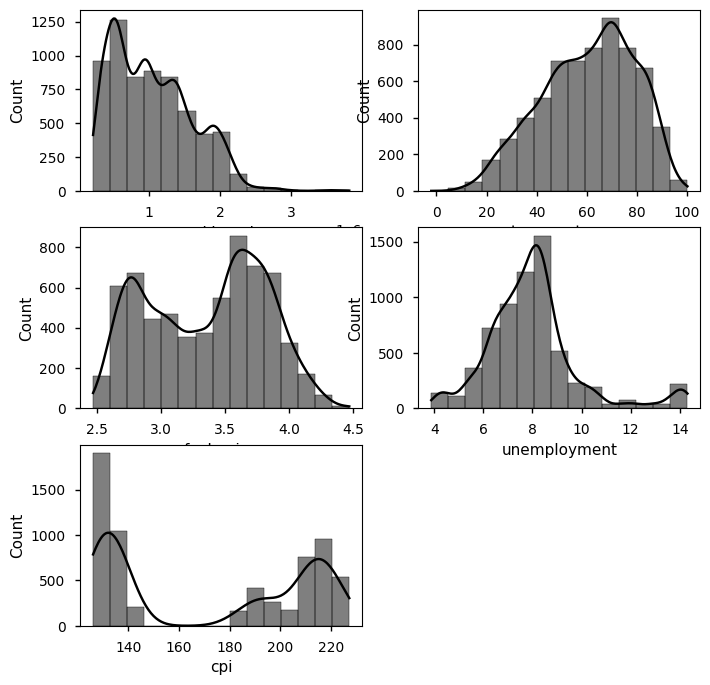

In [66]:
columns = ['weekly_sales', 'temperature', 'fuel_price', 'unemployment', 'cpi']
plt.figure(figsize=(8, 8))
for i,col in enumerate(columns):
    plt.subplot(3, 2, i+1)
    sns.histplot(data = data, x = col, kde = True, bins = 15, color = 'black')
plt.show()

Observations: Considering the numerical parameters of Weekly Sales, CPI, Fuel Price, Temperature and Unemployment and its histogram:
1. Weekly Sales data distribution is right skewed which indicates the rise in weekly sales over particular point of time such as holidays/weekends.
2. CPI (Consumer Price Index) and Fuel Price have bimodal discribution while Temperature and Unemployment have normal disctribution

Considering the Categorical Features of Holiday Flag, Year, Season, Month and Day of the Week

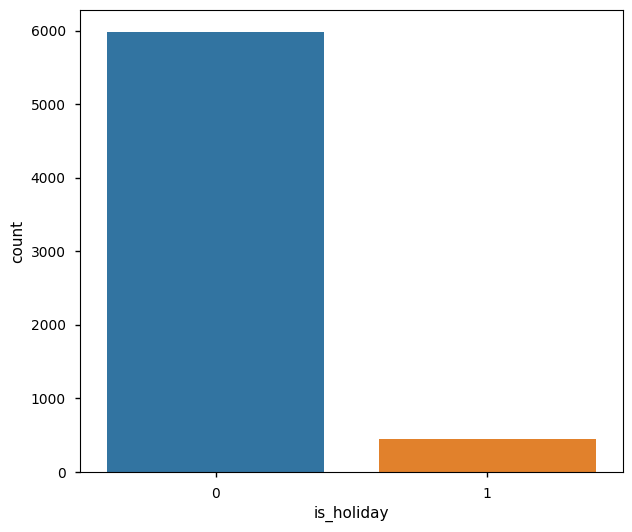

In [67]:
fig, ax = plt.subplots(figsize=(7, 6))
sns.countplot(data=data, x='is_holiday', ax=ax)
plt.show()

The count of Normal days are much higher than Holidays which is as expected

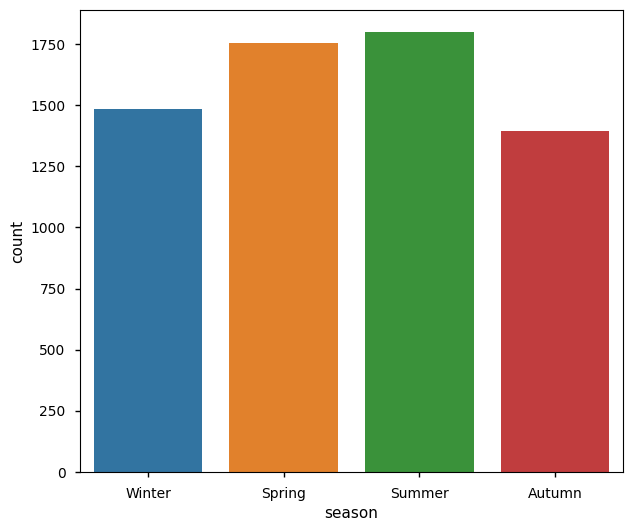

In [68]:
fig, ax = plt.subplots(figsize=(7, 6))
sns.countplot(data=data, x='season', ax=ax)
plt.show()

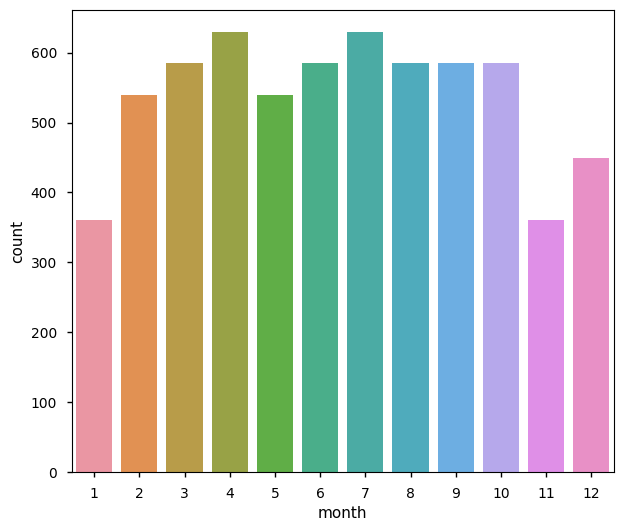

In [69]:
fig, ax = plt.subplots(figsize=(7, 6))
sns.countplot(data=data, x='month', ax=ax)
plt.show()

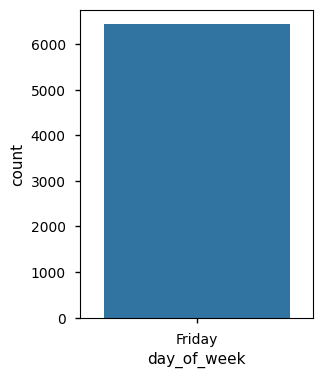

In [70]:
fig, ax = plt.subplots(figsize=(3, 4))
sns.countplot(data=data, x='day_of_week', ax=ax)
plt.show()

In [71]:
data.day_of_week.value_counts()

Friday    6435
Name: day_of_week, dtype: int64

Multi-variable analysis (Attributes vs Weekly Sales)

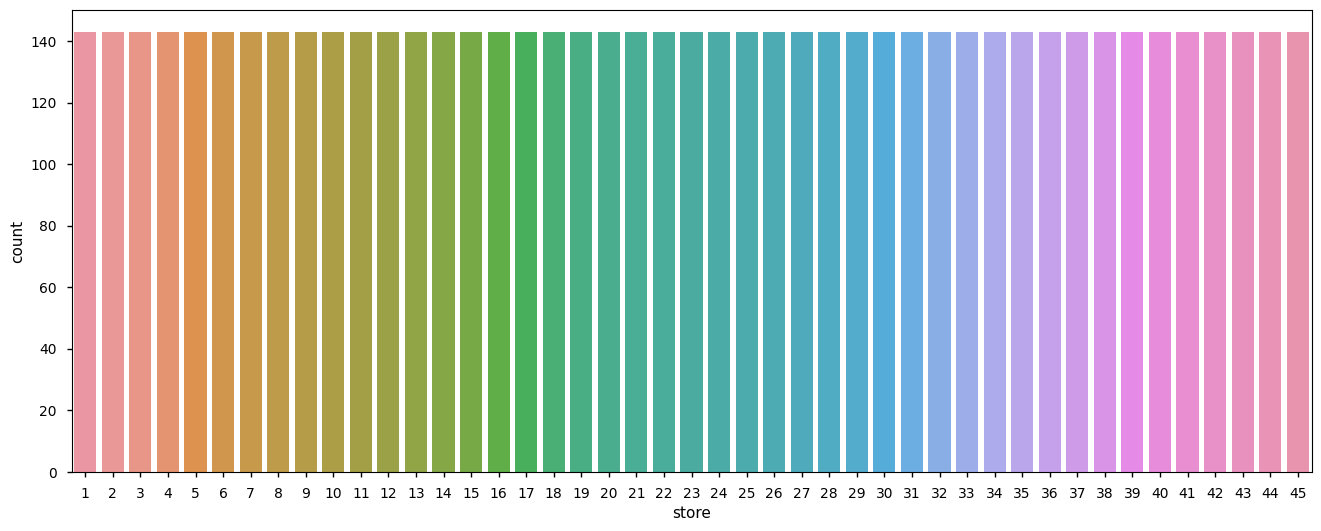

In [72]:
plt.figure(figsize=(16, 6))
sns.countplot(data = data, x = 'store')
plt.show()

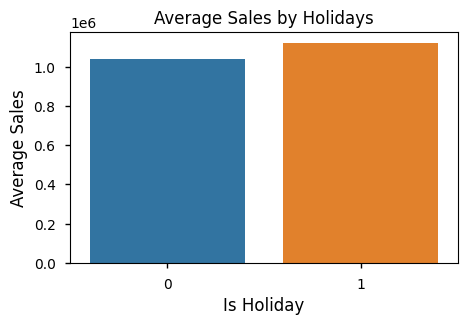

In [73]:
plt.figure(figsize = (5, 3))
sns.barplot(data = data,
            x = 'is_holiday',
            y = 'weekly_sales',
            estimator = np.mean,
            ci = False)

# Add labels and title
plt.title('Average Sales by Holidays')
plt.xlabel('Is Holiday', size = 12)
plt.ylabel('Average Sales', size = 12)
plt.show()

Sales on Holidays is higher than normal days

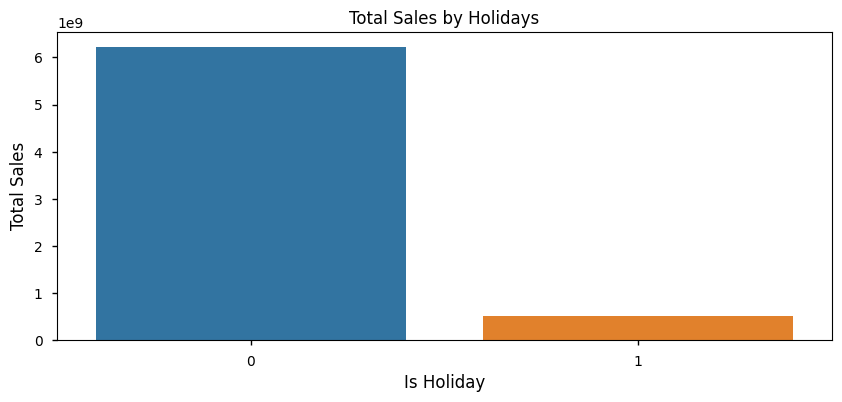

In [74]:
plt.figure(figsize = (10, 4))
sns.barplot(data = data,
            x = 'is_holiday',
            y = 'weekly_sales',
            estimator = np.sum,
            ci = False)

# Add labels and title
plt.title('Total Sales by Holidays')
plt.xlabel('Is Holiday', size = 12)
plt.ylabel('Total Sales', size = 12)
plt.show()

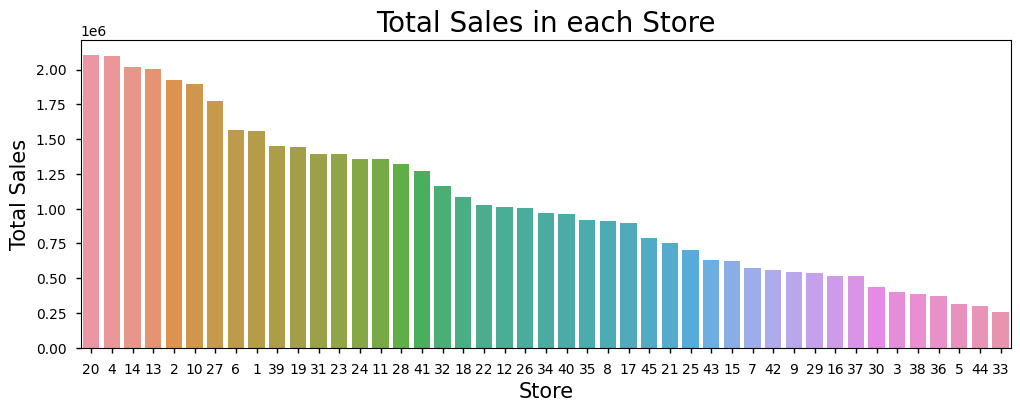

In [75]:
gb_store = data.groupby('store')['weekly_sales'].sum().sort_values(ascending = False)
plt.figure(figsize = (12, 4))
sns.barplot(data = data,
            x = 'store',
            y = 'weekly_sales',
            order = gb_store.index,
            ci = False)

# Add labels and title
plt.title('Total Sales in each Store', size = 20)
plt.xlabel('Store', size = 15)
plt.ylabel('Total Sales', size = 15)
plt.show()

Text(0.5, 1.0, 'Fuel Price')

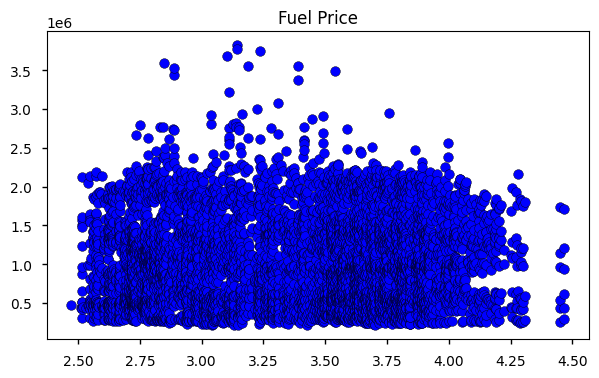

In [76]:
plt.figure(figsize = (7, 4))
plt.scatter(data.sort_values('fuel_price')['fuel_price'], data.sort_values('fuel_price')['weekly_sales'], color='b', edgecolors='black')
plt.title('Fuel Price')


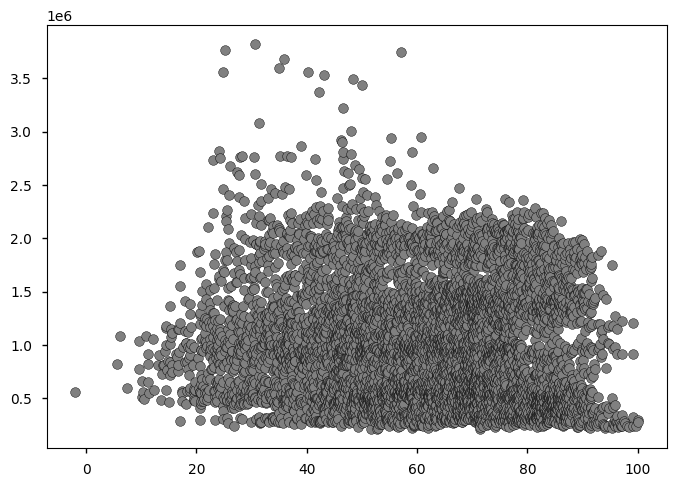

In [77]:
plt.scatter(data.sort_values('temperature').temperature, data.sort_values('temperature').weekly_sales, color = 'gray', edgecolors='black')

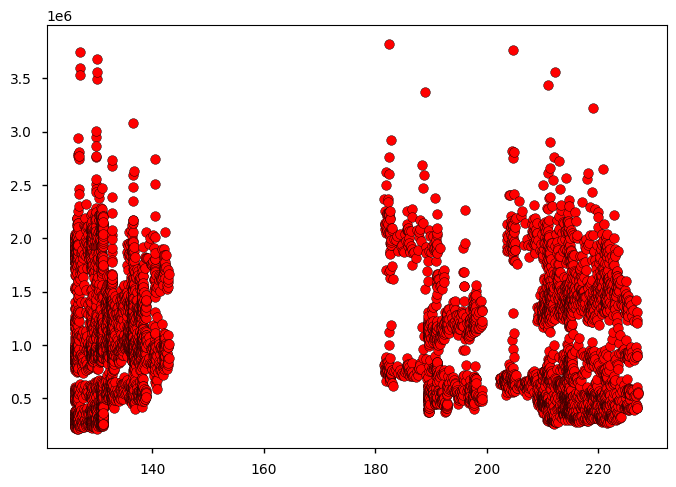

In [78]:
plt.scatter(data.sort_values('cpi').cpi, data.sort_values('cpi').weekly_sales, color = 'r', edgecolors='black')

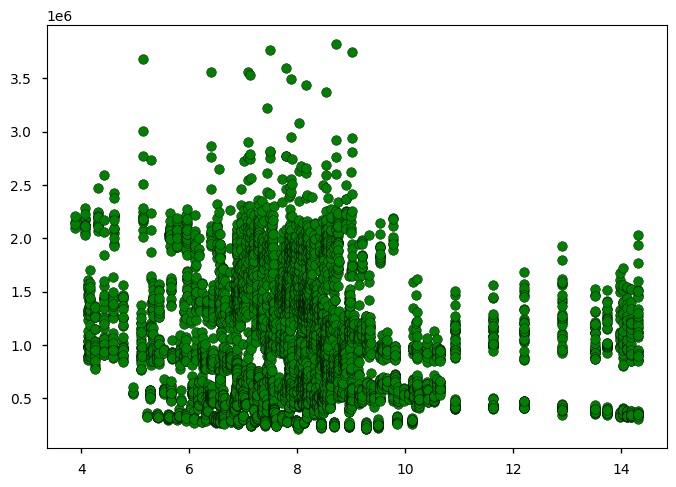

In [79]:
plt.scatter(data.sort_values('unemployment').unemployment, data.sort_values('unemployment').weekly_sales, color = 'g', edgecolors='black')

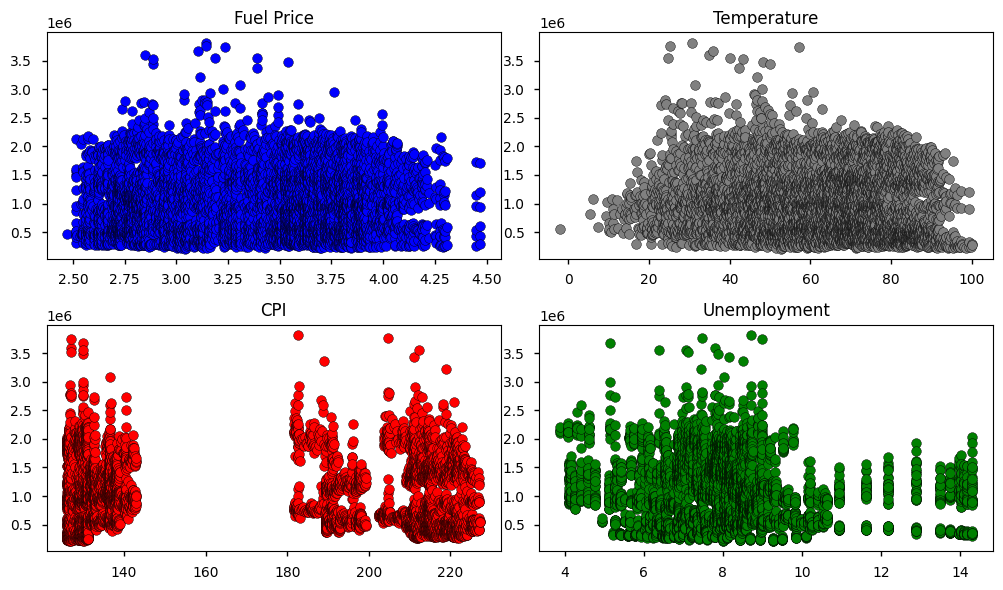

In [80]:
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# Scatter plot for Fuel Price
axes[0, 0].scatter(data.sort_values('fuel_price')['fuel_price'], data.sort_values('fuel_price')['weekly_sales'], color='b', edgecolors='black')
axes[0, 0].set_title('Fuel Price')

# Scatter plot for Temperature
axes[0, 1].scatter(data.sort_values('temperature')['temperature'], data.sort_values('temperature')['weekly_sales'], color='gray', edgecolors='black')
axes[0, 1].set_title('Temperature')

# Scatter plot for CPI
axes[1, 0].scatter(data.sort_values('cpi')['cpi'], data.sort_values('cpi')['weekly_sales'], color='r', edgecolors='black')
axes[1, 0].set_title('CPI')

# Scatter plot for Unemployment
axes[1, 1].scatter(data.sort_values('unemployment')['unemployment'], data.sort_values('unemployment')['weekly_sales'], color='g', edgecolors='black')
axes[1, 1].set_title('Unemployment')

# Adjust layout
plt.tight_layout()

plt.show()


In [81]:
# Let's calculate the Pearson Correlation Coefficient and P-value of 'fuel_price' and 'weekly_sales':
categorical_columns = ['temperature', 'fuel_price', 'unemployment', 'cpi']
target_column = 'weekly_sales'
for cat_column in categorical_columns:
  pearson_coef, p_value = stats.pearsonr(data[cat_column], data['weekly_sales'])
  print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is -0.06381001317946956  with a P-value of P = 3.007647625833226e-07
The Pearson Correlation Coefficient is 0.009463786314475135  with a P-value of P = 0.44782874894858093
The Pearson Correlation Coefficient is -0.10617608965795423  with a P-value of P = 1.3448365210234661e-17
The Pearson Correlation Coefficient is -0.07263416204017623  with a P-value of P = 5.438292612176735e-09


In [82]:
from scipy import stats
import pandas as pd

# Assuming 'data' is your DataFrame

numerical_columns = ['temperature', 'fuel_price', 'unemployment', 'cpi']
target_column = 'weekly_sales'

for num_column in numerical_columns:
    pearson_coef, p_value = stats.pearsonr(data[num_column], data[target_column])
    print(f"The Pearson Correlation Coefficient between {num_column} and {target_column} is {pearson_coef:.4f} with a P-value of {p_value:.4f}")


The Pearson Correlation Coefficient between temperature and weekly_sales is -0.0638 with a P-value of 0.0000
The Pearson Correlation Coefficient between fuel_price and weekly_sales is 0.0095 with a P-value of 0.4478
The Pearson Correlation Coefficient between unemployment and weekly_sales is -0.1062 with a P-value of 0.0000
The Pearson Correlation Coefficient between cpi and weekly_sales is -0.0726 with a P-value of 0.0000


In [83]:
data.head()

,store,date,weekly_sales,is_holiday,temperature,fuel_price,cpi,unemployment,year,quarter,season,month,month_name,week,day_of_week
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,2010,1,Winter,2,February,5,Friday
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,2010,1,Winter,2,February,6,Friday
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,2010,1,Winter,2,February,7,Friday
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,2010,1,Winter,2,February,8,Friday
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,2010,1,Winter,3,March,9,Friday


In [84]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# Assuming 'data' is your DataFrame
categorical_columns = ['is_holiday', 'year', 'season', 'month_name', 'day_of_week']
target_column = 'weekly_sales'

# Create a function to calculate Cramér's V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()  # Sum twice to get the total count
    min_dim = min(confusion_matrix.shape) - 1
    return np.sqrt(chi2 / (n * min_dim))

# Calculate Cramér's V for each categorical variable
for cat_column in categorical_columns:
    confusion_matrix = pd.crosstab(data[cat_column], data[target_column])
    v_value = cramers_v(confusion_matrix)
    print(f"Cramér's V for {cat_column} vs. {target_column}: {v_value:.4f}")


Cramér's V for is_holiday vs. weekly_sales: 1.0000
Cramér's V for year vs. weekly_sales: 1.0000
Cramér's V for season vs. weekly_sales: 1.0000
Cramér's V for month_name vs. weekly_sales: 1.0000
Cramér's V for day_of_week vs. weekly_sales: nan


In [85]:
data_bkp = data.copy()

In [86]:
data_prep = data_bkp.copy()

In [87]:
data_prep.drop(['date', 'year', 'quarter', 'month', 'day_of_week'], axis = 1, inplace = True)

In [88]:
data_prep.dtypes

store             int64
weekly_sales    float64
is_holiday        int64
temperature     float64
fuel_price      float64
cpi             float64
unemployment    float64
season           object
month_name       object
week              int32
dtype: object

In [89]:
data_prep['store'] = data_prep['store'].astype('object')
data_prep['is_holiday'] = data_prep['is_holiday'].astype('object')
data_prep['week'] = data_prep['week'].astype('object')

In [90]:
data_prep.dtypes

store            object
weekly_sales    float64
is_holiday       object
temperature     float64
fuel_price      float64
cpi             float64
unemployment    float64
season           object
month_name       object
week             object
dtype: object

0 fuel_price
1 temperature
2 cpi
3 unemployment


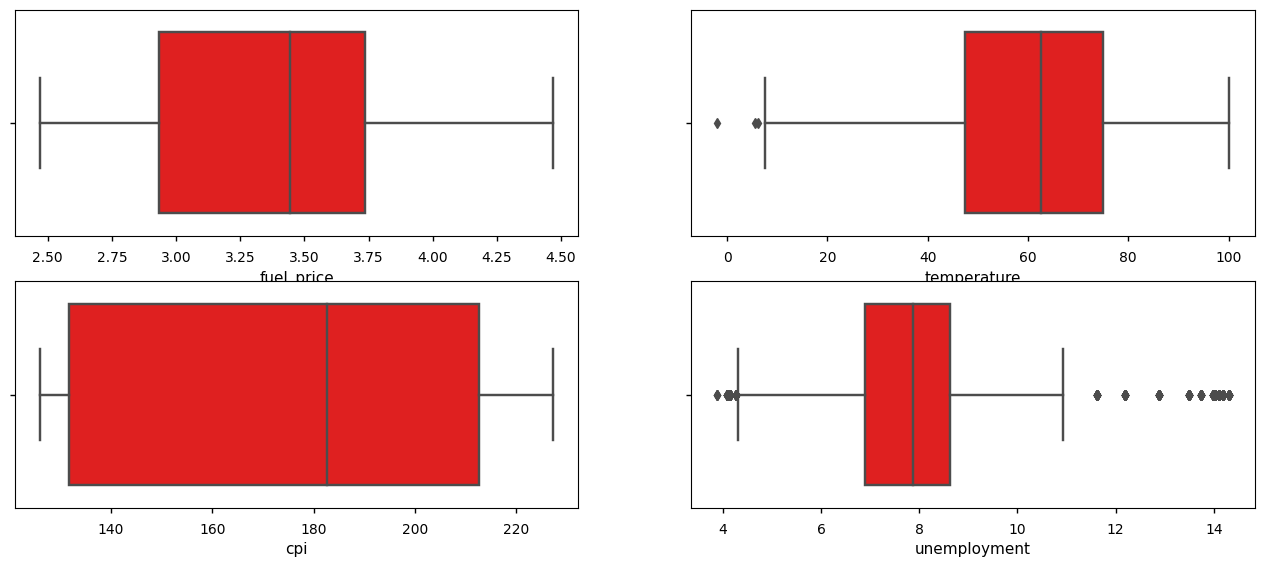

Number of data rows:  6435


In [91]:
cols = ['fuel_price', 'temperature', 'cpi', 'unemployment']
plt.figure(figsize=(16,10))
for i,col in enumerate(cols):
    print(i, col)
    plt.subplot(3,2,i+1)
    sns.boxplot(data_prep, x = col, color = 'red')
plt.show()

print('Number of data rows: ', data_prep.shape[0])

In [92]:
data_prep.drop(data_prep[data_prep['temperature'] < 7].index, axis = 0, inplace = True)

In [93]:
data_prep.drop(data_prep[data_prep['unemployment'] < 4.4].index, axis = 0, inplace = True)
data_prep.drop(data_prep[data_prep['unemployment'] > 11].index, axis = 0, inplace = True)

0 temperature
1 fuel_price
2 cpi
3 unemployment


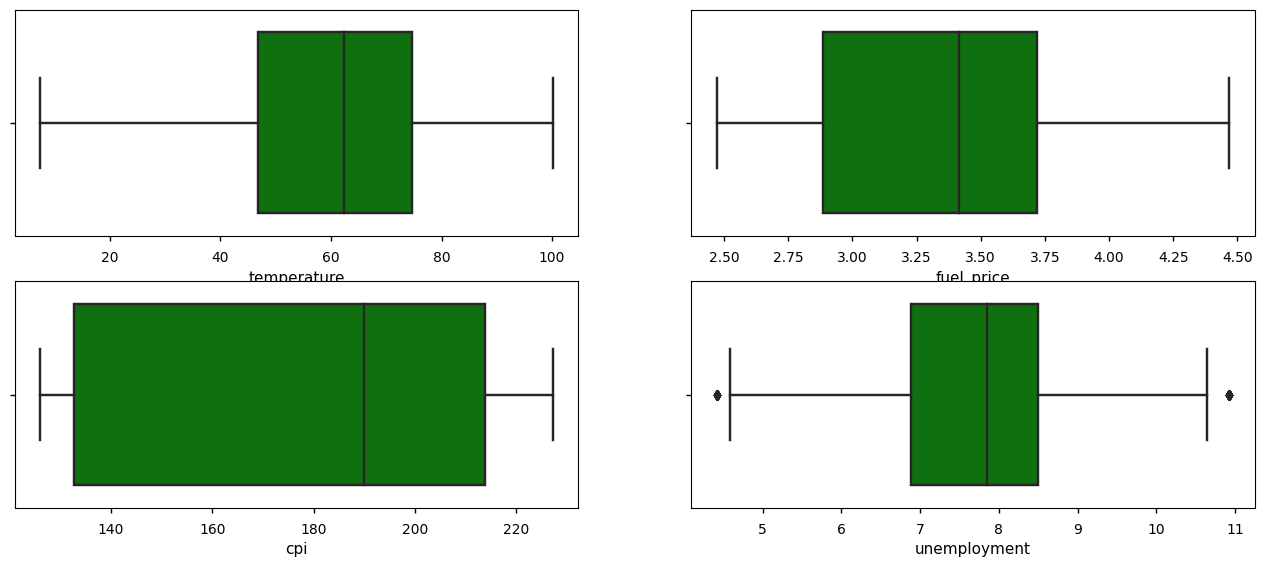

Number of data rows:  5938


In [94]:
cols = ['temperature', 'fuel_price', 'cpi', 'unemployment']
plt.figure(figsize=(16,10))
for i, col in enumerate(cols):
    print(i, col)
    plt.subplot(3,2,i+1)
    sns.boxplot(data_prep, x = col, color = 'g')
plt.show()

print('Number of data rows: ', data_prep.shape[0])

In [95]:
X = data_prep.drop('weekly_sales', axis = 1)
y = data_prep['weekly_sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)

In [96]:
print('Shape of data      : ', X.shape)
print('Shape of train data: ', X_train.shape)
print('Shape of test data : ', X_test.shape)
print('Shape of test data : ', y_train.shape)
print('Shape of test data : ', y_test.shape)

Shape of data      :  (5938, 9)
Shape of train data:  (4750, 9)
Shape of test data :  (1188, 9)
Shape of test data :  (4750,)
Shape of test data :  (1188,)


In [97]:
num_features = data_prep.select_dtypes('number').columns.to_list()
num_features.remove('weekly_sales')

cat_features = data_prep.select_dtypes('object').columns.to_list()

print(f'Numerical Features : {num_features}')
print(f'Categorical Features: {cat_features}')

Numerical Features : ['temperature', 'fuel_price', 'cpi', 'unemployment']
Categorical Features: ['store', 'is_holiday', 'season', 'month_name', 'week']


In [98]:
# data transformation pipeline
preprocessor = ColumnTransformer([
                                  ('num_features', StandardScaler(), num_features),
                                  ('cat_features', BinaryEncoder(), cat_features),
                                ])

# Fitting the training data
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('num_features', StandardScaler(),
                                 ['temperature', 'fuel_price', 'cpi',
                                  'unemployment']),
                                ('cat_features', BinaryEncoder(),
                                 ['store', 'is_holiday', 'season', 'month_name',
                                  'week'])])

In [99]:
# Transform the training data
X_train_transformed = preprocessor.transform(X_train)

# Transform the testing data
X_test_transformed = preprocessor.transform(X_test)

In [100]:
data_prep

,store,weekly_sales,is_holiday,temperature,fuel_price,cpi,unemployment,season,month_name,week
0,1,1643690.90,0,42.31,2.572,211.096358,8.106,Winter,February,5
1,1,1641957.44,1,38.51,2.548,211.242170,8.106,Winter,February,6
2,1,1611968.17,0,39.93,2.514,211.289143,8.106,Winter,February,7
3,1,1409727.59,0,46.63,2.561,211.319643,8.106,Winter,February,8
4,1,1554806.68,0,46.50,2.625,211.350143,8.106,Winter,March,9
...,...,...,...,...,...,...,...,...,...,...
6430,45,713173.95,0,64.88,3.997,192.013558,8.684,Summer,September,39
6431,45,733455.07,0,64.89,3.985,192.170412,8.667,Autumn,October,40
6432,45,734464.36,0,54.47,4.000,192.327265,8.667,Autumn,October,41
6433,45,718125.53,0,56.47,3.969,192.330854,8.667,Autumn,October,42


In [101]:
'''def model_evaluation(estimator, Training_Testing, X, y):

    '''#This function is used to evaluate the model through RMSE and R2'''

    # Y predict of X train or X test
    #predict_data = estimator.predict(X)

    #print(f'{Training_Testing} Accuracy: \n')
    #rmse = {round(np.sqrt(mean_squared_error(y, predict_data)), 2)}
    #print(f'-> Root Mean Squared Error: {round(np.sqrt(mean_squared_error(y, predict_data)), 2)}')
    #print(f'-> R-Squere score Training: {round(r2_score(y, predict_data) * 100, 2)} % \n')'''

def model_evaluation(estimator, Training_Testing, X, y):

    ''' This function is used to evaluate the model through RMSE and R2'''

    # Y predict of X train or X test
    predict_data = estimator.predict(X)

    # Calculate RMSE
    rmse = round(np.sqrt(mean_squared_error(y, predict_data)), 2)

    # Calculate the range of the target variable
    target_range = np.max(y) - np.min(y)

    # Calculate normalized RMSE
    normalized_rmse = rmse / target_range
    R2= {round(r2_score(y, predict_data) * 100, 2)}
    print(f'{Training_Testing} Accuracy: \n')
    print(f'-> Root Mean Squared Error: {rmse}')
    print(f'-> Normalized Root Mean Squared Error: {normalized_rmse}')
    print(f'-> R-Square score {Training_Testing}: {R2} % \n')



def Distribution_Plot(estimator, Training_Testing, X, y, Title):

    """This function is used to perform some model evaluation using training and testing data \
    by plotting the distribution of the actual and predicted values of the training or testing data."""

    # Y predict of X train or X test
    yhat = estimator.predict(X)
    plt.figure(figsize=(14, 6))
    ax1 = sns.distplot(y, hist = False, color = "b", label = f'Actual Values ({Training_Testing})')
    ax2 = sns.distplot(yhat, hist = False, color = "r", label = f'Predicted Values ({Training_Testing})', ax = ax1)
    plt.title(Title, size = 18)
    plt.legend()
    plt.show()

    plt.figure(figsize=(10,10))
    plt.scatter(y, yhat, c='crimson')
    plt.yscale('log')
    plt.xscale('log')

    p1 = max(max(yhat), max(y))
    p2 = min(min(yhat), min(y))
    plt.plot([p1, p2], [p1, p2], 'b-')
    plt.xlabel('True Values', fontsize=15)
    plt.ylabel('Predictions', fontsize=15)
    plt.axis('equal')
    plt.show()


def cross_validation_score(estimator, X_train, y_train, score = 'r2', n = 5):

    '''This function is to validate the model'''


    validate = cross_val_score(estimator, X_train, y_train, scoring = score, cv = n)

    print(f'Cross Validation Scores: {validate} \n')
    print(f'Mean of Scores: {round(validate.mean() * 100, 2)} % \n')
    print(f'Standard Deviation of Scores: {validate.std()}')

def hyperparameter_tunning(estimator, X_train, y_train, param_grid, score = 'r2', n = 5):

    '''This function is used to find the best set of hyperparameters for the model to optimize its performance'''


    # Perform grid search
    grid_search = GridSearchCV(estimator = estimator,
                               param_grid = param_grid,
                               scoring = score,
                               cv = n, verbose=3, n_jobs=-1)

    # Fit the data
    grid_search.fit(X_train,y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    # Print the best parameters and score
    print(f'Best parameters: {best_params} \n')
    print(f'Best score: {best_score}')

    # best estimator
    best_estimator = grid_search.best_estimator_

    return best_estimator


In [102]:
# Linear Regression Model
LR = LinearRegression()

# Fitting the data
LR.fit(X_train_transformed, y_train)

LinearRegression()

In [103]:
# Training Accuracy
model_evaluation(LR, 'Training', X_train_transformed, y_train)

Training Accuracy: 

-> Root Mean Squared Error: 496405.9
-> Normalized Root Mean Squared Error: 0.1375580880894456
-> R-Square score Training: {24.26} % 



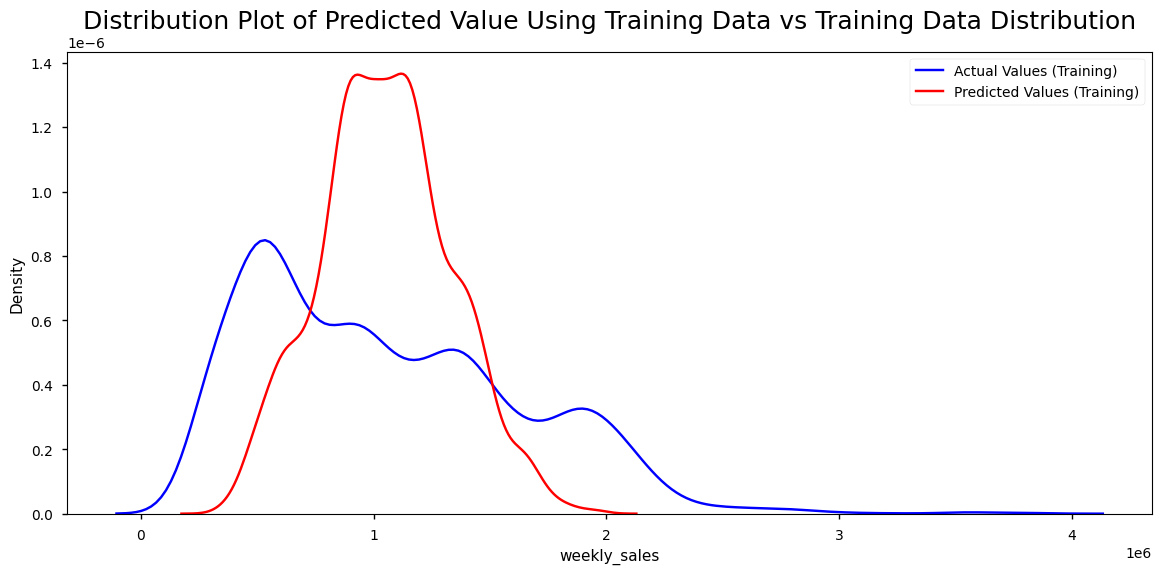

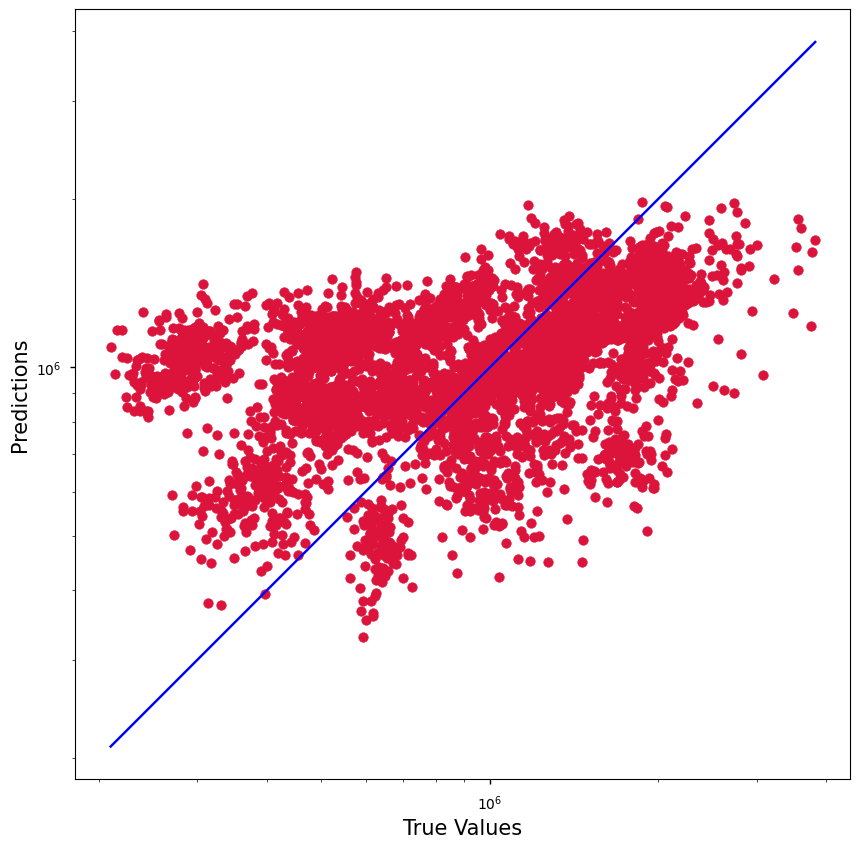

In [104]:
# Figure 1: Plot of predicted values using the training data compared to the actual values of the training data.
Title = 'Distribution Plot of Predicted Value Using Training Data vs Training Data Distribution'
Distribution_Plot(LR, 'Training', X_train_transformed, y_train, Title)

In [105]:
# Polynomial Regression Model
LR_pipe = Pipeline([('poly_feat', PolynomialFeatures()),
                    ('lin_reg', LinearRegression())])

# Define the parameter grid to search
param_grid = {'poly_feat__degree': [2, 3, 4]}

best_estimator = hyperparameter_tunning(LR_pipe, X_train_transformed, y_train, param_grid, score = 'r2', n = 5)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters: {'poly_feat__degree': 3} 

Best score: 0.9642124337561426


In [106]:
# Linear Regression Model after tuning
poly_reg = best_estimator

In [107]:
# Training Accuracy Afer tuning
model_evaluation(poly_reg, 'Training', X_train_transformed, y_train)

Training Accuracy: 

-> Root Mean Squared Error: 66100.14
-> Normalized Root Mean Squared Error: 0.018316883181373724
-> R-Square score Training: {98.66} % 



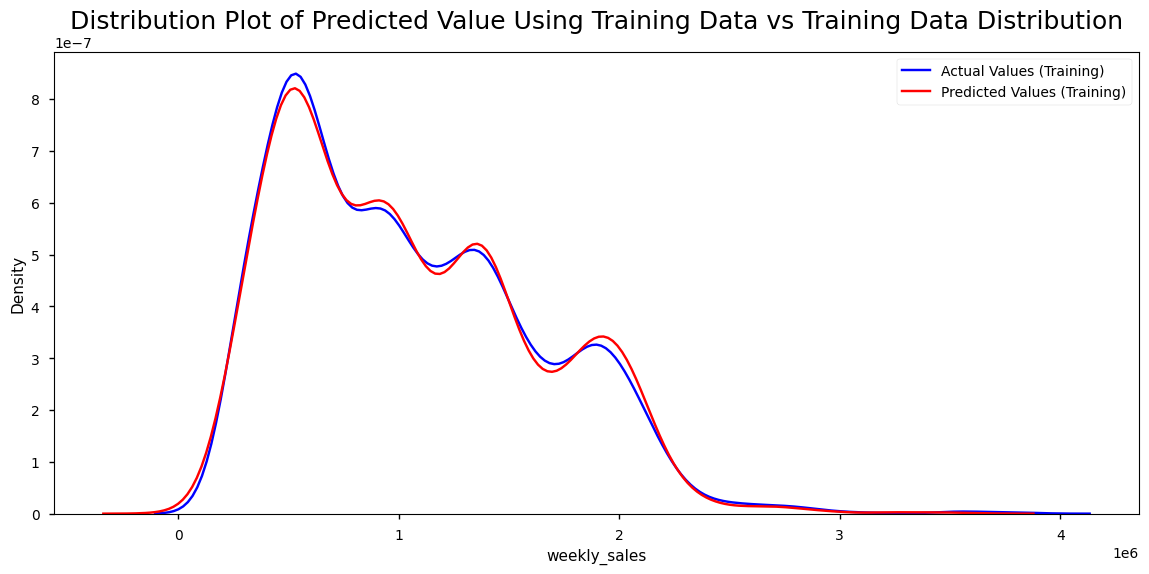

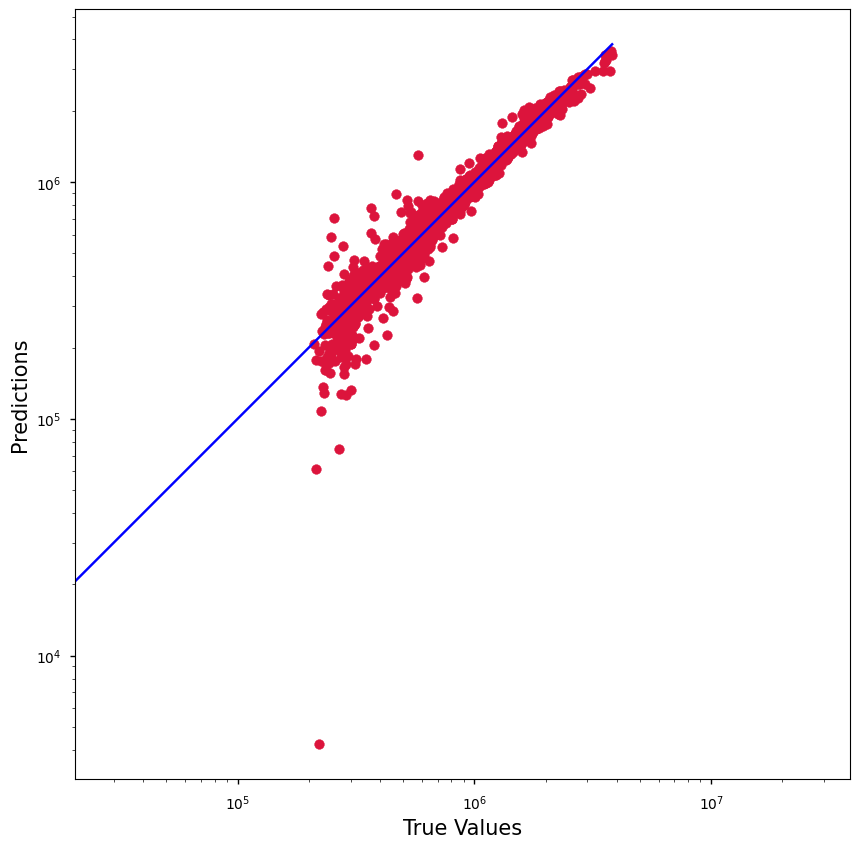

In [108]:
# Figure 2: Plot of predicted values using the training data compared to the actual values of the training data.
Title = 'Distribution Plot of Predicted Value Using Training Data vs Training Data Distribution'
Distribution_Plot(poly_reg, 'Training', X_train_transformed, y_train, Title)

In [109]:
cross_validation_score(poly_reg, X_train_transformed, y_train)

Cross Validation Scores: [0.95955817 0.96588319 0.96974753 0.96201577 0.96514597] 

Mean of Scores: 96.45 % 

Standard Deviation of Scores: 0.0034772298717269763


In [110]:
# Testing Accuracy
model_evaluation(poly_reg, 'Testing', X_test_transformed, y_test)

Testing Accuracy: 

-> Root Mean Squared Error: 96614.21
-> Normalized Root Mean Squared Error: 0.027991283255091242
-> R-Square score Testing: {97.13} % 



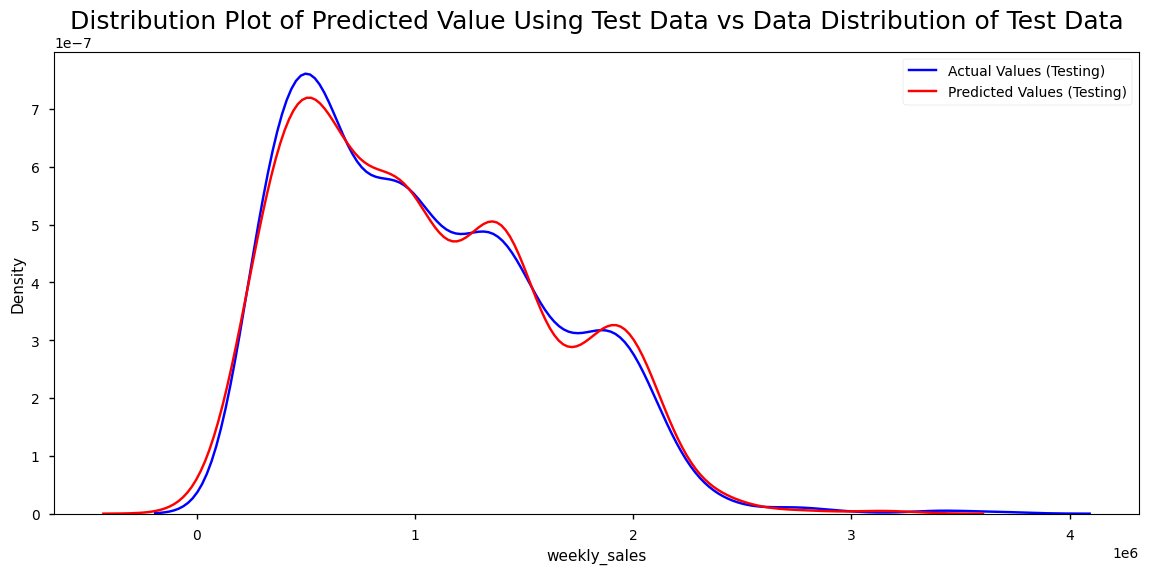

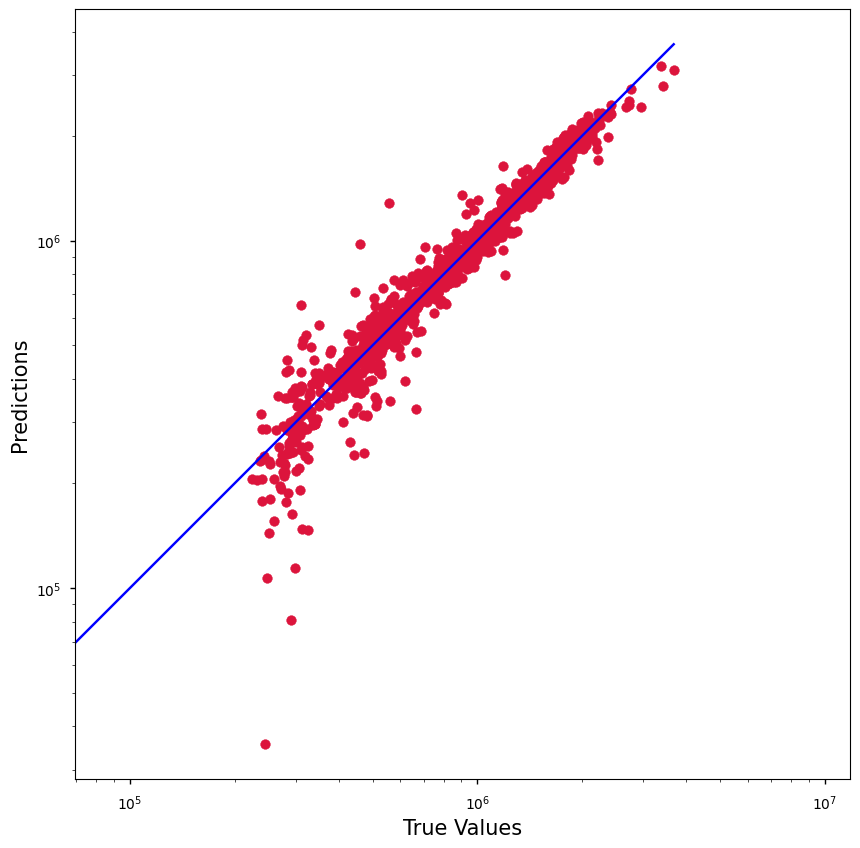

In [111]:
# Figure 3: Plot of predicted value using the test data compared to the actual values of the test data.
Title='Distribution Plot of Predicted Value Using Test Data vs Data Distribution of Test Data'
Distribution_Plot(poly_reg, 'Testing', X_test_transformed, y_test, Title)


Decision Tree Algorithm

Training Accuracy: 

-> Root Mean Squared Error: 0.0
-> Normalized Root Mean Squared Error: 0.0
-> R-Square score Training: {100.0} % 



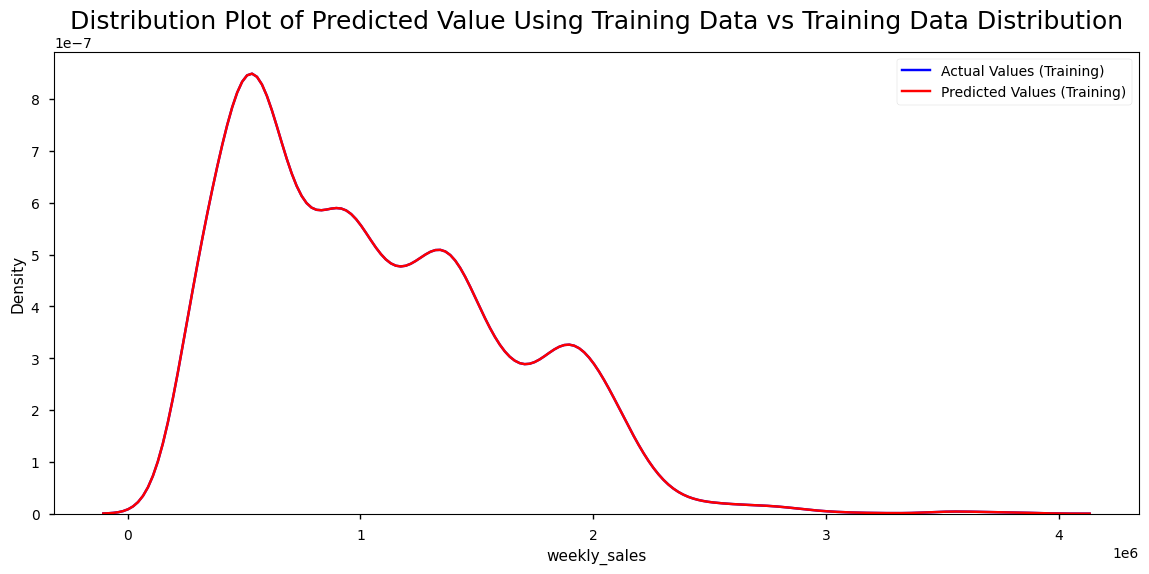

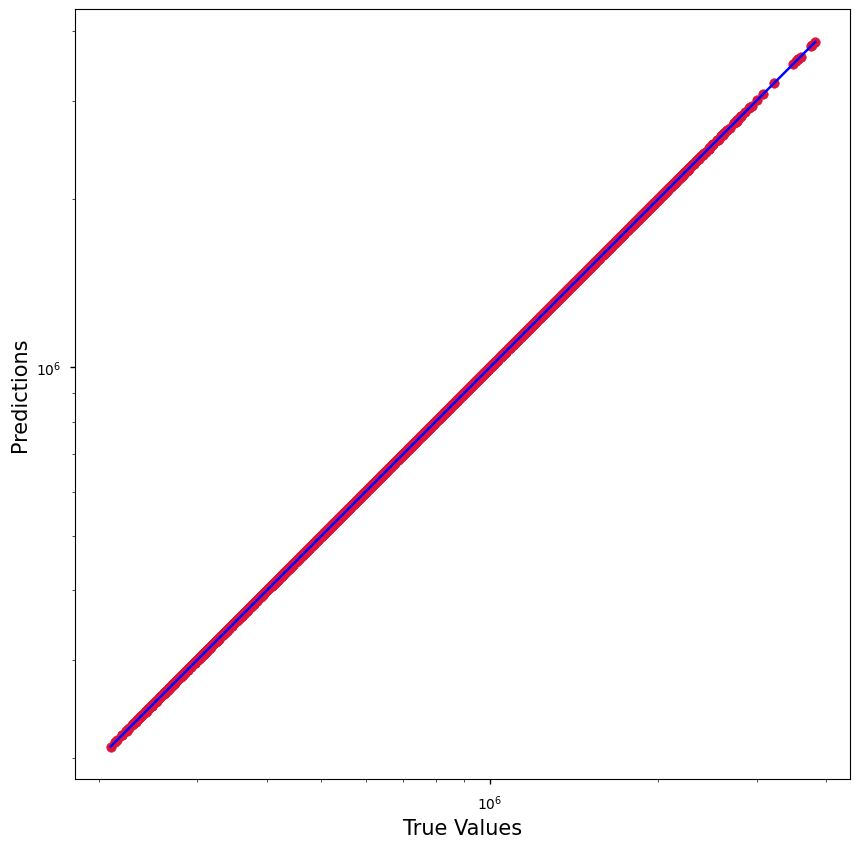

Fitting 5 folds for each of 104 candidates, totalling 520 fits
Best parameters: {'max_depth': 13, 'min_samples_split': 30} 

Best score: 0.9163030668094129


In [112]:
# Decision Tree regressor Model
tree = DecisionTreeRegressor()

# Fitting the training data
tree.fit(X_train_transformed, y_train)

# Training Accuracy
model_evaluation(tree, 'Training', X_train_transformed, y_train)

# Figure 1: Plot of predicted values using the training data compared to the actual values of the training data.
Title = 'Distribution Plot of Predicted Value Using Training Data vs Training Data Distribution'
Distribution_Plot(tree, 'Training', X_train_transformed, y_train, Title)

# Define the parameter grid to search
param_grid = {'max_depth': np.arange(2, 15),
              'min_samples_split': [10, 20, 30, 40, 50, 100, 200, 300]}

best_estimator = hyperparameter_tunning(tree, X_train_transformed, y_train, param_grid, score = 'r2', n = 5)

Best_Tree = best_estimator



In [113]:
model_evaluation(Best_Tree, 'Training', X_train_transformed, y_train)

Training Accuracy: 

-> Root Mean Squared Error: 120723.62
-> Normalized Root Mean Squared Error: 0.03345349109355218
-> R-Square score Training: {95.52} % 



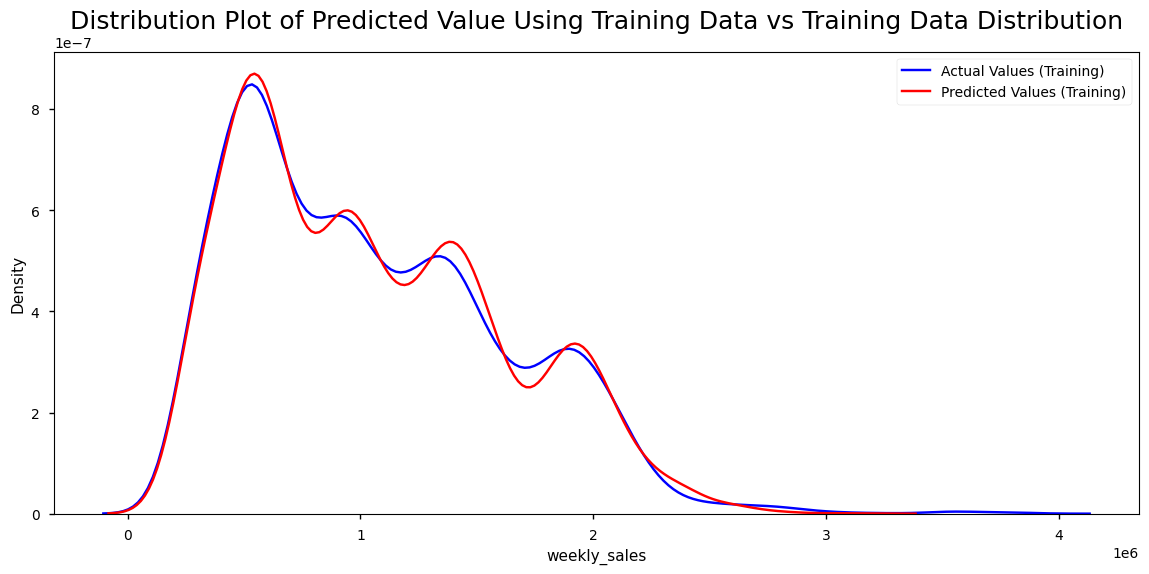

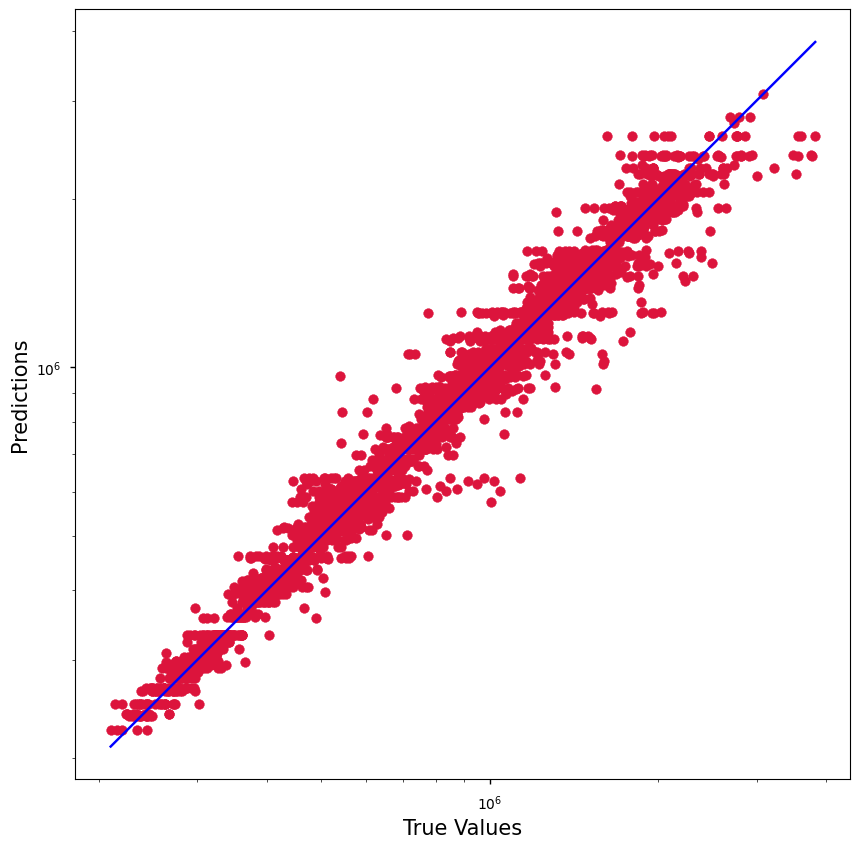

In [114]:
Title = 'Distribution Plot of Predicted Value Using Training Data vs Training Data Distribution'
Distribution_Plot(Best_Tree, 'Training', X_train_transformed, y_train, Title)

In [115]:
cross_validation_score(Best_Tree, X_train_transformed, y_train, n = 10)

Cross Validation Scores: [0.91612992 0.93674064 0.9278914  0.92195092 0.88405018 0.91331679
 0.92468291 0.90900891 0.89630786 0.94763668] 

Mean of Scores: 91.78 % 

Standard Deviation of Scores: 0.01765373204085632


In [116]:
# Testing Accuracy
model_evaluation(Best_Tree, 'Testing', X_test_transformed, y_test)

Testing Accuracy: 

-> Root Mean Squared Error: 168894.73
-> Normalized Root Mean Squared Error: 0.04893255586028346
-> R-Square score Testing: {91.22} % 



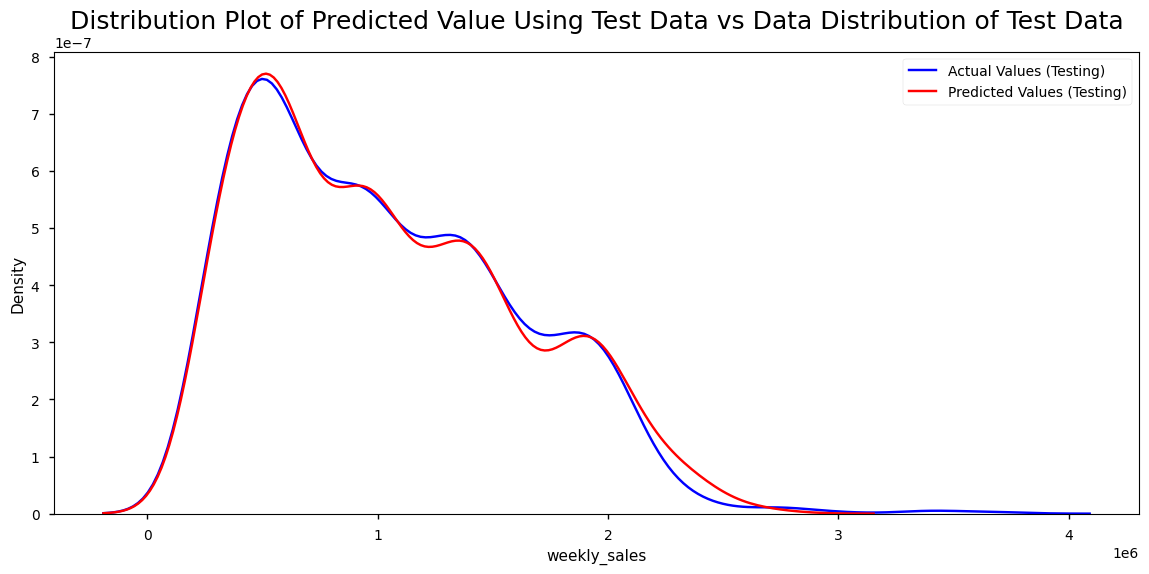

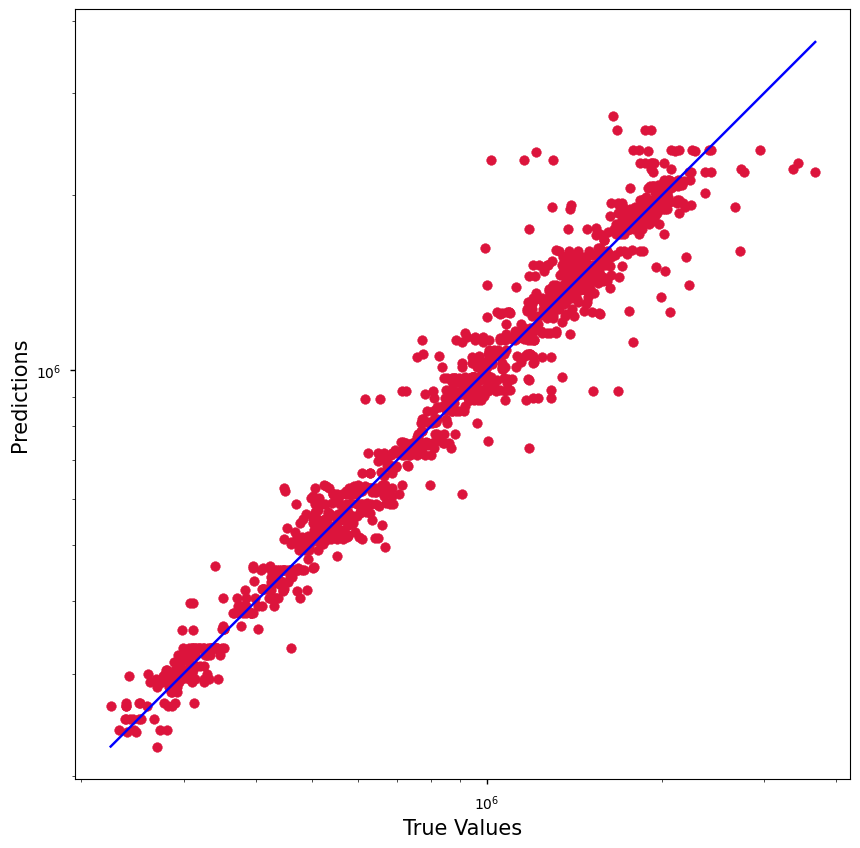

In [117]:
# Figure 3: Plot of predicted value using the test data compared to the actual values of the test data.
Title='Distribution Plot of Predicted Value Using Test Data vs Data Distribution of Test Data'
Distribution_Plot(Best_Tree, 'Testing', X_test_transformed, y_test, Title)

Random Forest Regressor

In [118]:
RF = RandomForestRegressor() # Random Forest Regressor Model

In [119]:
RF.fit(X_train_transformed, y_train) #Fitting the Training Data

RandomForestRegressor()

In [120]:
y_pred = RF.predict(X_test_transformed)

In [121]:
model_evaluation(RF, 'Training', X_train_transformed, y_train)


Training Accuracy: 

-> Root Mean Squared Error: 51689.21
-> Normalized Root Mean Squared Error: 0.014323497973037494
-> R-Square score Training: {99.18} % 



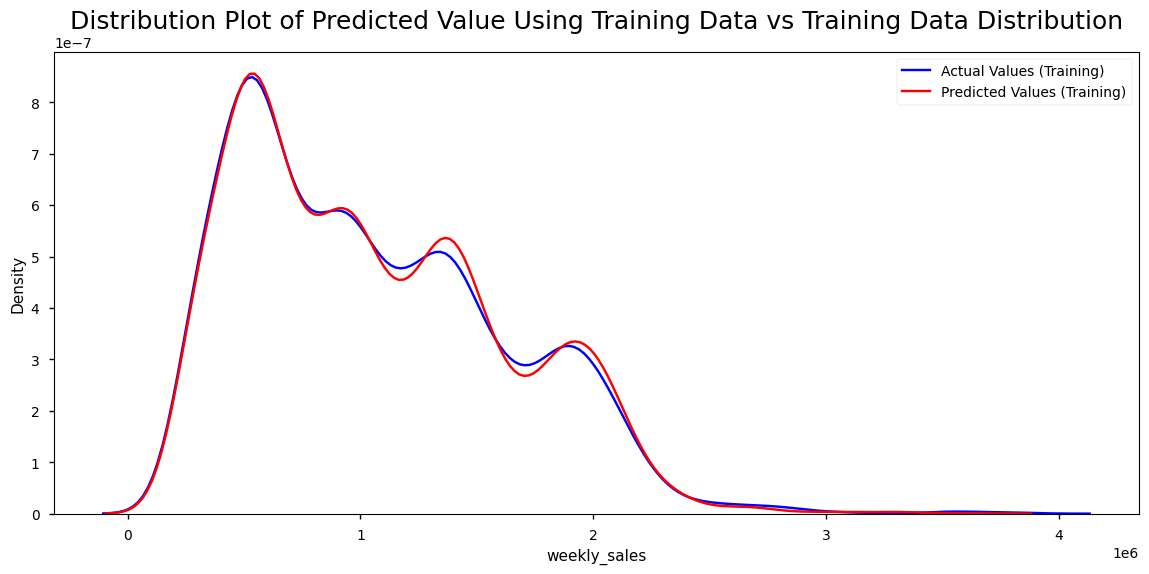

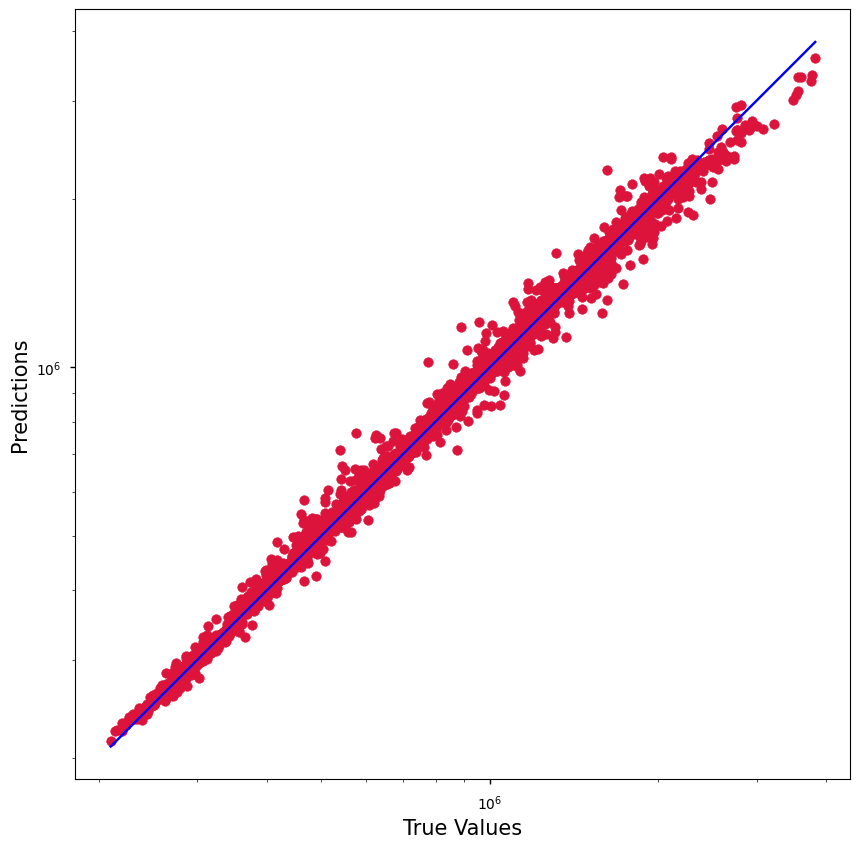

In [122]:
# Plot of predicted values using the training data compared to the actual values of the training data.
Title = 'Distribution Plot of Predicted Value Using Training Data vs Training Data Distribution'
Distribution_Plot(RF, 'Training', X_train_transformed, y_train, Title)


In [123]:
# Define the parameter grid to search
param_grid = {'n_estimators': [25, 50, 70, 100],
              'max_features': [None, 1,3,5,8],
              'max_depth': np.arange(2,15),
              'min_samples_split': [2,5,10],
              'min_samples_leaf': [1, 2, 4]
              }

best_estimator = hyperparameter_tunning(RF, X_train_transformed, y_train, param_grid, score = 'r2', n = 5)

Best_RF = best_estimator

Fitting 5 folds for each of 2340 candidates, totalling 11700 fits
Best parameters: {'max_depth': 14, 'max_features': 8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 70} 

Best score: 0.9436914558769199


In [124]:
model_evaluation(Best_RF, 'Training', X_train_transformed, y_train)

Training Accuracy: 

-> Root Mean Squared Error: 55199.23
-> Normalized Root Mean Squared Error: 0.015296152891836235
-> R-Square score Training: {99.06} % 



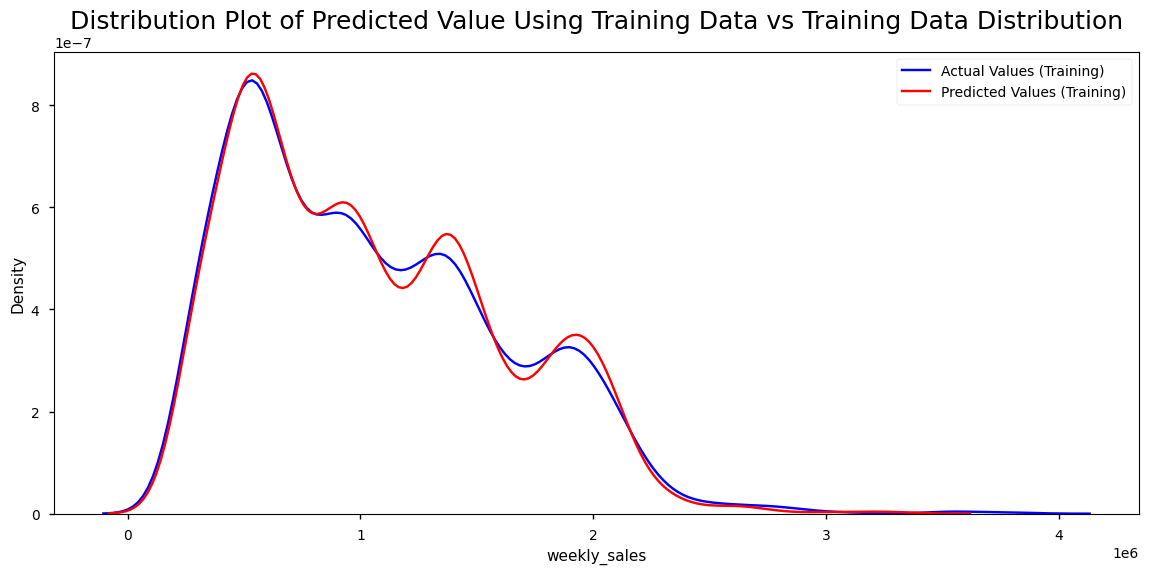

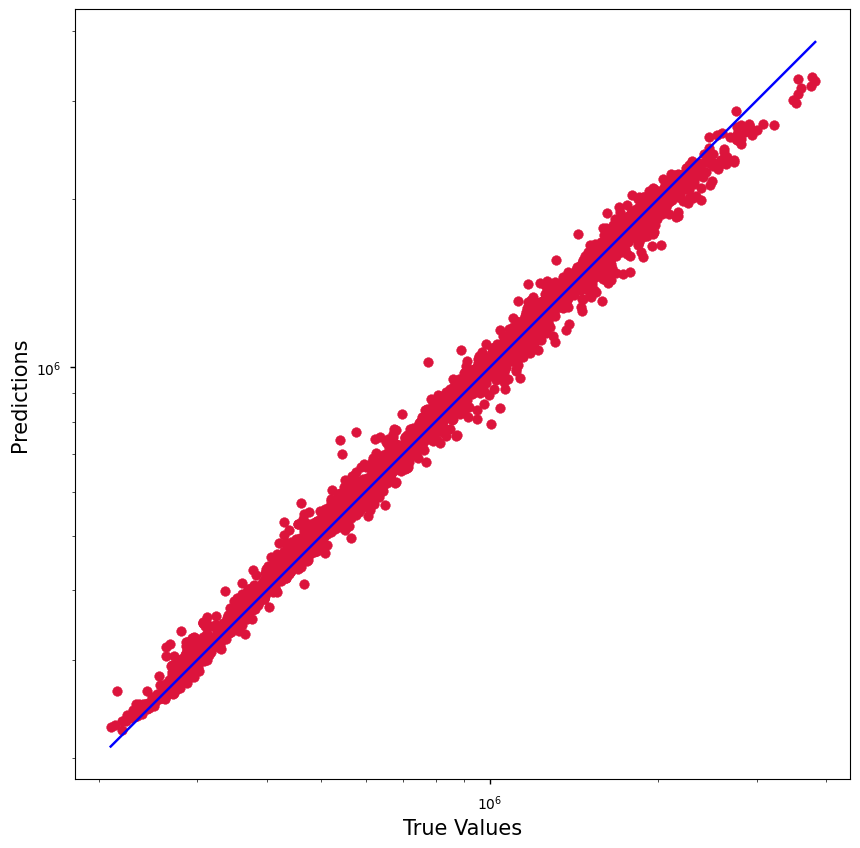

In [125]:
Title = 'Distribution Plot of Predicted Value Using Training Data vs Training Data Distribution'
Distribution_Plot(Best_RF, 'Training', X_train_transformed, y_train, Title)

In [126]:
cross_validation_score(Best_RF, X_train_transformed, y_train, n = 10)

Cross Validation Scores: [0.94372224 0.95224094 0.94774706 0.94307089 0.92997839 0.95047328
 0.95215728 0.93792037 0.93657662 0.96320551] 

Mean of Scores: 94.57 % 

Standard Deviation of Scores: 0.009053443430509272


In [127]:
# Testing Accuracy
model_evaluation(Best_RF, 'Testing', X_test_transformed, y_test)

Testing Accuracy: 

-> Root Mean Squared Error: 130037.33
-> Normalized Root Mean Squared Error: 0.03767470372904538
-> R-Square score Testing: {94.8} % 



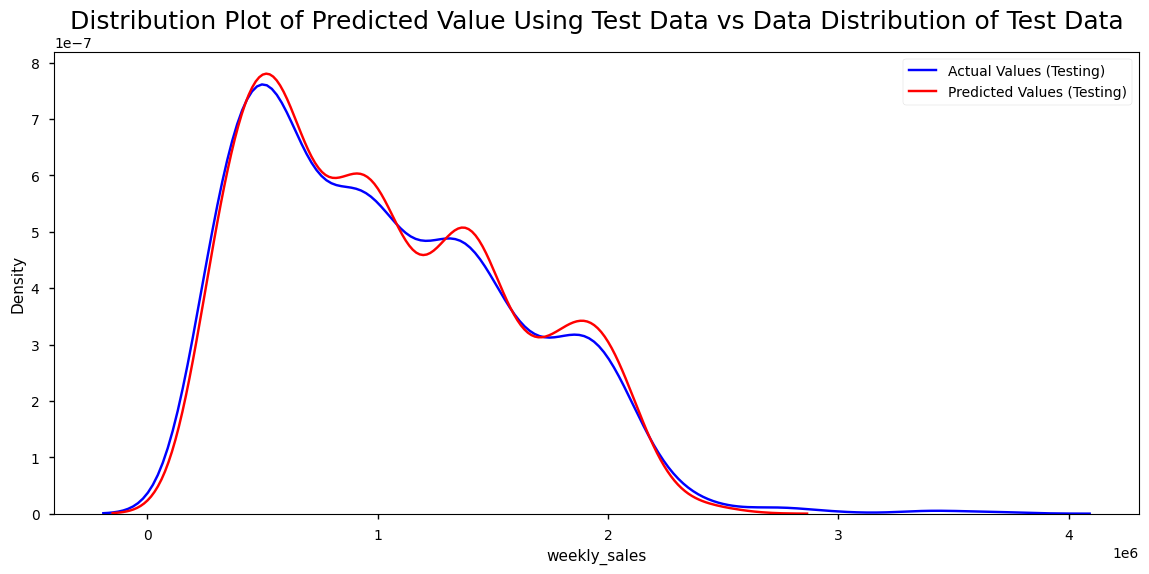

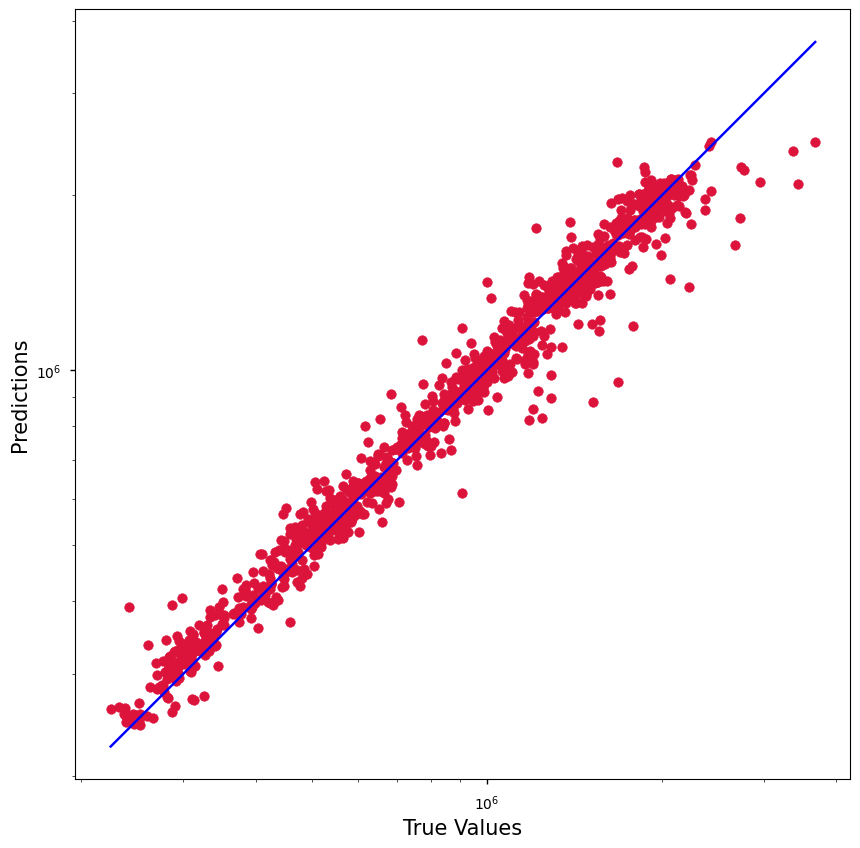

In [128]:
# Figure 3: Plot of predicted value using the test data compared to the actual values of the test data.
Title='Distribution Plot of Predicted Value Using Test Data vs Data Distribution of Test Data'
Distribution_Plot(Best_RF, 'Testing', X_test_transformed, y_test, Title)

XGBoost Algorithm

In [129]:
xgb_model = XGBRegressor()

In [130]:
xgb_model.fit(X_train_transformed, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [131]:
model_evaluation(xgb_model, 'Training', X_train_transformed, y_train)

Training Accuracy: 

-> Root Mean Squared Error: 31333.27
-> Normalized Root Mean Squared Error: 0.008682702431196695
-> R-Square score Training: {99.7} % 



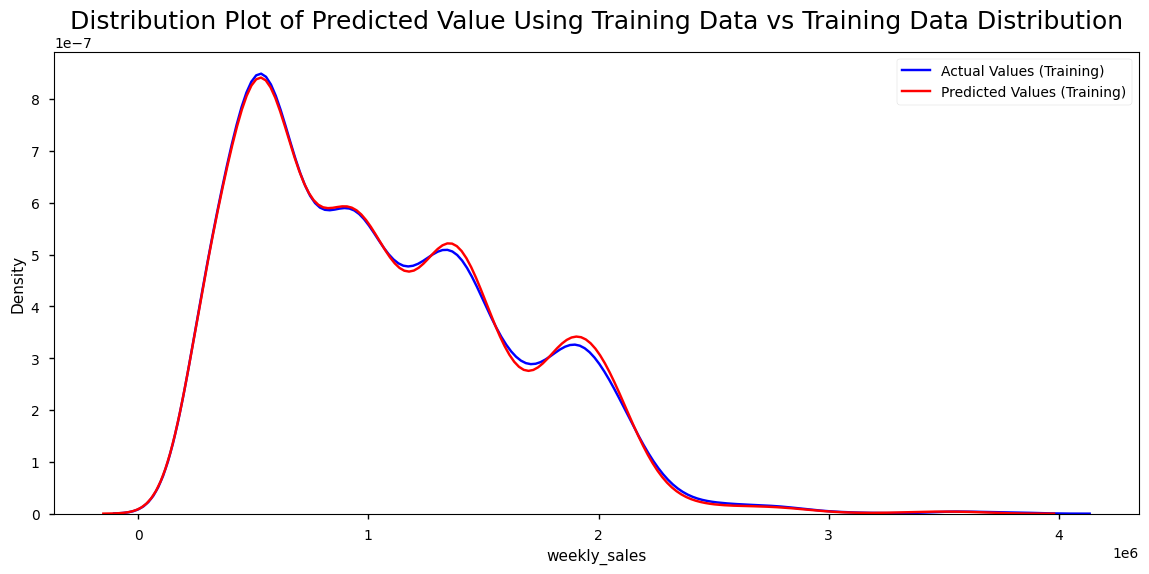

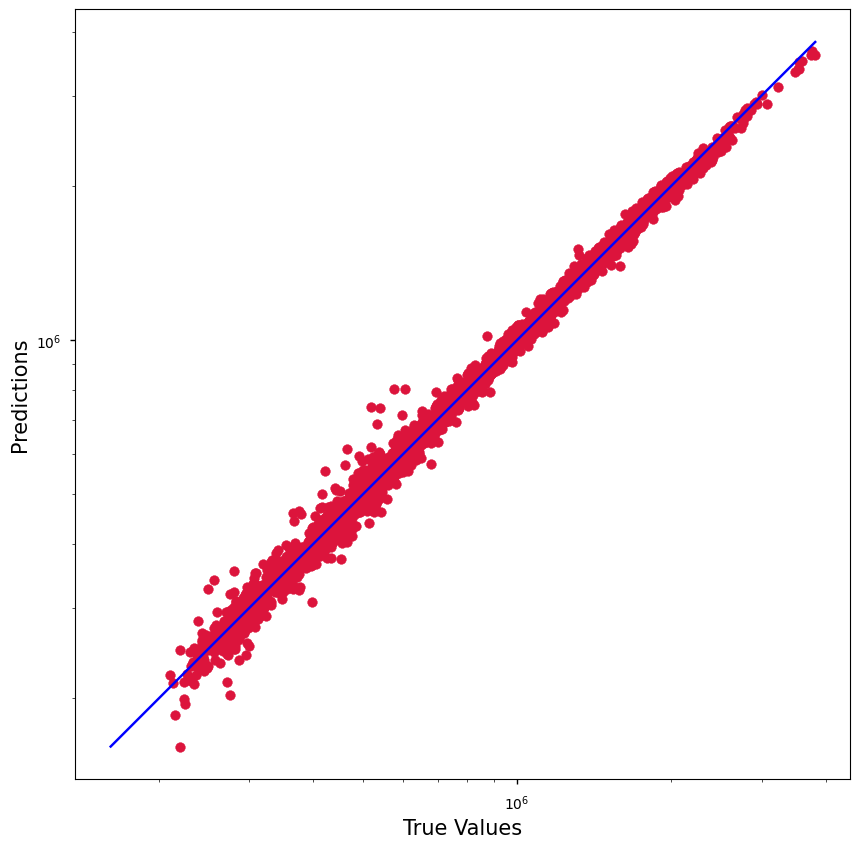

In [132]:
# Plot of predicted values using the training data compared to the actual values of the training data.
Title = 'Distribution Plot of Predicted Value Using Training Data vs Training Data Distribution'
Distribution_Plot(xgb_model, 'Training', X_train_transformed, y_train, Title)

In [133]:
# Define the parameter grid to search
param_grid = {
    'max_depth': np.arange(2,10),
    'n_estimators': np.arange(20,201,20)
}

best_estimator = hyperparameter_tunning(xgb_model, X_train_transformed, y_train, param_grid, score = 'r2', n = 5)

Best_xgb_model = best_estimator

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best parameters: {'max_depth': 7, 'n_estimators': 60} 

Best score: 0.9676665296193615


In [134]:
model_evaluation(Best_xgb_model, 'Training', X_train_transformed, y_train)

Training Accuracy: 

-> Root Mean Squared Error: 30205.35
-> Normalized Root Mean Squared Error: 0.008370146680513942
-> R-Square score Training: {99.72} % 



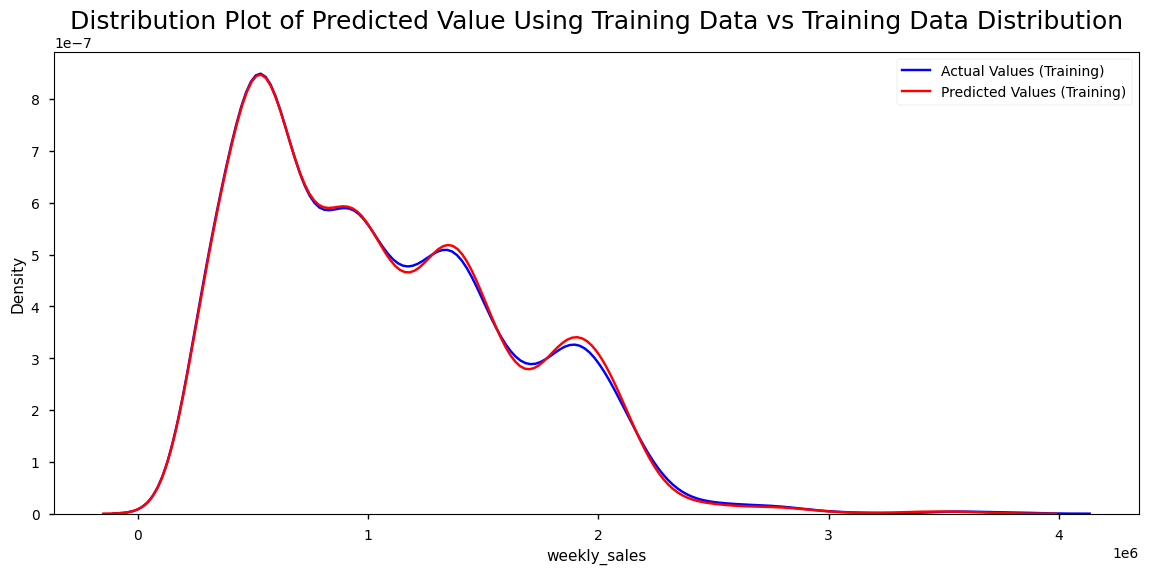

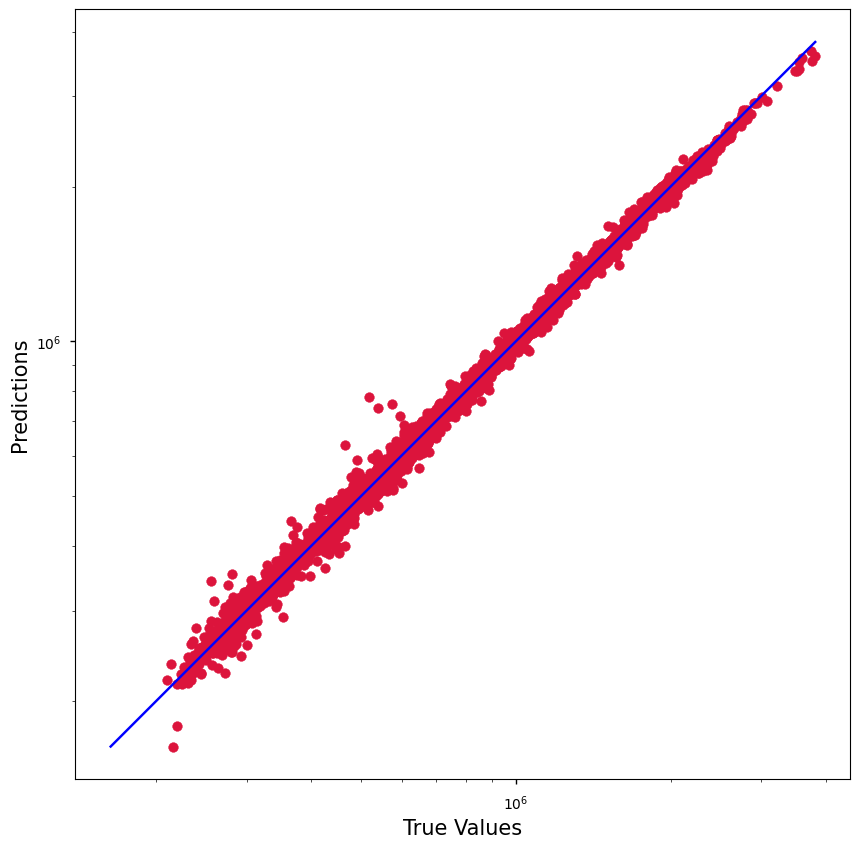

In [135]:
Title = 'Distribution Plot of Predicted Value Using Training Data vs Training Data Distribution'
Distribution_Plot(Best_xgb_model, 'Training', X_train_transformed, y_train, Title)

In [136]:
cross_validation_score(Best_xgb_model, X_train_transformed, y_train, n = 10)

Cross Validation Scores: [0.96349866 0.97354279 0.96550554 0.96408454 0.96671613 0.97188208
 0.96104139 0.96091998 0.96999453 0.9694661 ] 

Mean of Scores: 96.67 % 

Standard Deviation of Scores: 0.004196612602538904


In [137]:
# Testing Accuracy
model_evaluation(Best_xgb_model, 'Testing', X_test_transformed, y_test)

Testing Accuracy: 

-> Root Mean Squared Error: 89179.02
-> Normalized Root Mean Squared Error: 0.025837143513686517
-> R-Square score Testing: {97.55} % 



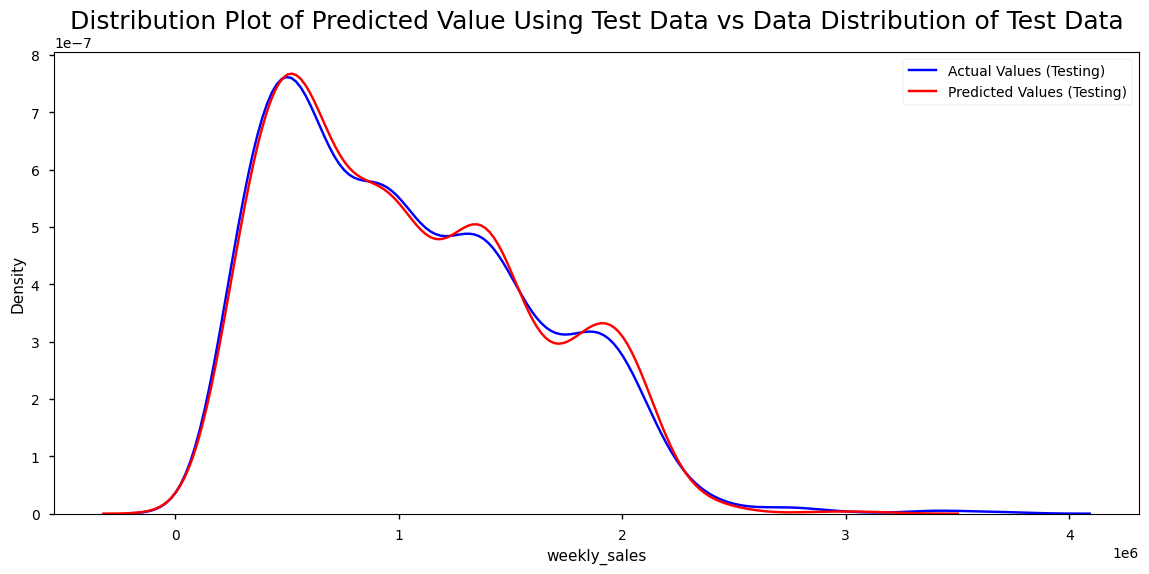

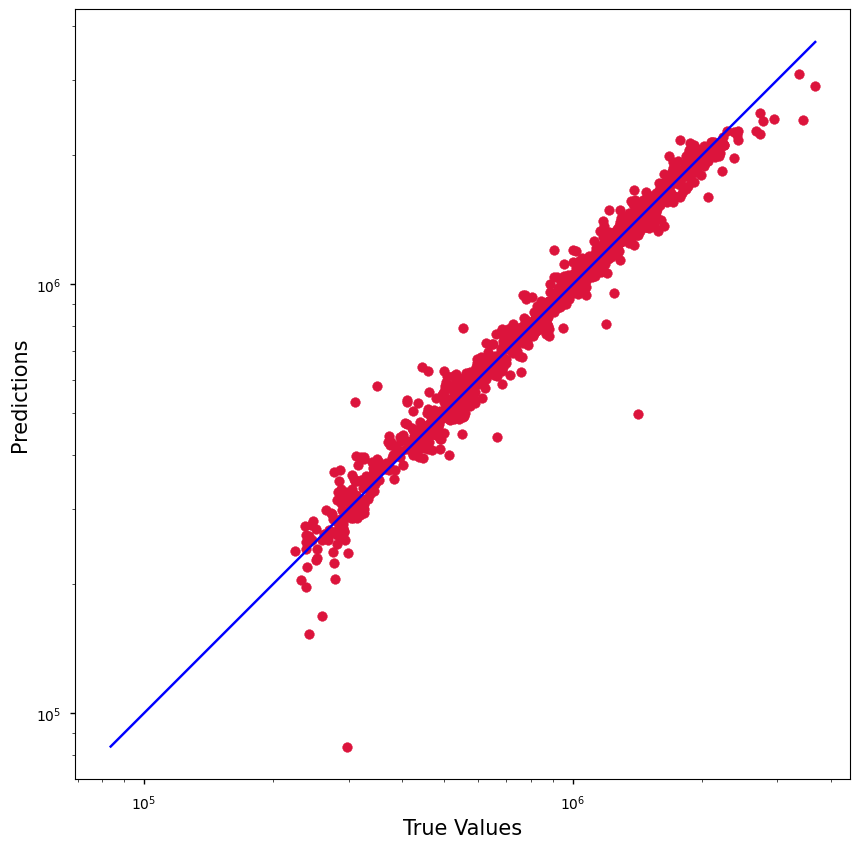

In [138]:
# Figure 3: Plot of predicted value using the test data compared to the actual values of the test data.
Title='Distribution Plot of Predicted Value Using Test Data vs Data Distribution of Test Data'
Distribution_Plot(Best_xgb_model, 'Testing', X_test_transformed, y_test, Title)